# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [51]:
import warnings

import alphalens
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
from backtrader_plotting import Bokeh, OptBrowser
from backtrader_plotting.schemes import Tradimo
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [52]:
#%matplotlib inline

from pathlib import Path
import csv
from time import time
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

from data.data_loader import data_loader

In [53]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [54]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [55]:
# https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/
# https://medium.com/@gk_/crypto-quant-programmatic-trading-of-btc-using-binance-and-backtrader-part-2-of-3-d8af44c93e2b
class CommInfoFractional(bt.CommissionInfo):
    params = dict(stocklike=True,
                  commission=.0075,
                  commtype = bt.CommInfoBase.COMM_PERC)# No margin, no multiplier
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


### DataFrame Loader


In [56]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    OHLCV = ['open', 'high', 'low', 'close', 'volume']
    cols = OHLCV + ['predicted']

    # create linesReceives a timer notification where timer is the timer which was returned by add_timer, and when is the calling time. args and kwargs are any additional arguments passed to add_timer
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Create and Configure Cerebro Instance

In [57]:
def create_cerebro():
    cerebro = bt.Cerebro()  # create a "Cerebro" instance
    cash = 10000
    cerebro.broker.addcommissioninfo(CommInfoFractional())
    cerebro.broker.setcash(cash)
    return cerebro

cerebro = create_cerebro()

### Add input data


In [58]:
def get_eval_data(results_path = 'results_D_144_ncut_1yrs/', offset=18*60):
    factors = (pd.read_feather(results_path +'test_preds.ftr').set_index(['date', 'offset', 'ticker'])
                   .loc[:, :'# 3']
                   .mean(1)
                   .to_frame('predicted')
                    .sort_index())

    idx = pd.IndexSlice
    factors = (factors.loc[idx[:, offset, :], :].reset_index('offset', drop=True))

    tickers = factors.index.get_level_values('ticker').unique()
    start_date=factors.index.get_level_values('date').min()
    end_date=factors.index.get_level_values('date').max()
    print(f'from {start_date} to {end_date}')
    factors = (factors
          .dropna(how='all')
          .sort_index().tz_localize('UTC', level='date'))


    prices = pd.read_feather(results_path + 'prices.ftr').set_index(['date', 'offset', 'ticker'])
    prices = (prices.reorder_levels(['ticker', 'offset', 'date']).sort_index())

    idx = pd.IndexSlice
    prices = (prices.loc[idx[tickers, offset, start_date:end_date], :])

    prices.reset_index('offset', drop=True, inplace=True)
    prices = (prices.sort_index().tz_localize('UTC', level='date'))
    return prices, factors

prices, factors = get_eval_data()
data = factors.join(prices)

data.head()


from 2017-09-10 00:00:00 to 2021-06-19 00:00:00


predicted         open        close          low         high        volume
date                      ticker                                                                               
2017-09-10 00:00:00+00:00 btc-usd    0.001489  4272.600098  4210.799805  4123.000000  4383.200195  3.330845e+04
                          dash-usd   0.004245   323.200012   320.579987   315.000000   333.399994  1.153482e+04
                          eos-usd    0.008566     0.751070     0.735900     0.710000     0.760830  3.072870e+06
                          etc-usd   -0.006506    15.848000    15.445000    14.800000    15.998000  2.820340e+05
                          eth-usd   -0.011656   299.970001   298.700012   287.329987   308.000000  2.180439e+05

<AxesSubplot:xlabel='date'>

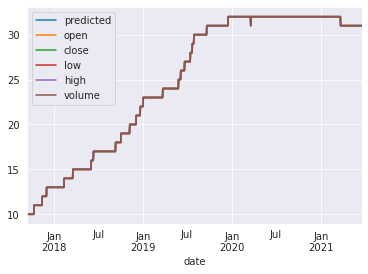

In [59]:
counts_df = data.groupby('date').count()
counts_df.plot()

<AxesSubplot:xlabel='ticker'>

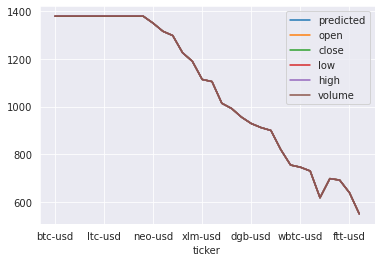

In [60]:
data.groupby('ticker').count().plot()

In [61]:
data=data.swaplevel()
data

,,predicted,open,close,low,high,volume
ticker,date,,,,,,
btc-usd,2017-09-10 00:00:00+00:00,0.001489,4272.600098,4210.799805,4123.000000,4383.200195,3.330845e+04
dash-usd,2017-09-10 00:00:00+00:00,0.004245,323.200012,320.579987,315.000000,333.399994,1.153482e+04
eos-usd,2017-09-10 00:00:00+00:00,0.008566,0.751070,0.735900,0.710000,0.760830,3.072870e+06
etc-usd,2017-09-10 00:00:00+00:00,-0.006506,15.848000,15.445000,14.800000,15.998000,2.820340e+05
eth-usd,2017-09-10 00:00:00+00:00,-0.011656,299.970001,298.700012,287.329987,308.000000,2.180439e+05
...,...,...,...,...,...,...,...
xlm-usd,2021-06-19 00:00:00+00:00,-0.007865,0.298630,0.287780,0.270160,0.298630,2.443947e+06
xmr-usd,2021-06-19 00:00:00+00:00,0.008838,278.480011,261.070007,248.740005,282.459991,3.934528e+03
xrp-usd,2021-06-19 00:00:00+00:00,0.020999,0.787090,0.732750,0.698280,0.789600,1.640989e+07


In [62]:

print("loading...")
def bt_adddata(bt_cerebro, data):
    idx = pd.IndexSlice
    tickers = data.index.get_level_values('ticker').unique()
    benchmark_btc = None

    for ticker in tqdm(tickers):
        df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
        df.index.name = 'datetime'
        bt_data = SignalData(dataname=df)
        bt_cerebro.adddata(bt_data, name=ticker)
        if ticker == 'btc-usd':
            benchmark_btc = df
    return benchmark_btc
benchmark_btc = bt_adddata(bt_cerebro=cerebro, data=data)
benchmark_btc

100%|██████████| 32/32 [00:00<00:00, 753.87it/s]

loading...


,predicted,open,close,low,high,volume
datetime,,,,,,
2017-09-10 00:00:00+00:00,0.001489,4272.600098,4210.799805,4123.000000,4383.200195,33308.448919
2017-09-11 00:00:00+00:00,0.004006,4216.799805,4228.100098,4152.500000,4379.000000,29558.226545
2017-09-12 00:00:00+00:00,0.004459,4179.000000,3900.000000,3731.699951,4207.000000,76780.061741
2017-09-13 00:00:00+00:00,0.027584,3901.100098,3337.000000,3311.000000,3949.899902,99975.586253
2017-09-14 00:00:00+00:00,0.001734,3315.500000,3514.899902,2980.399902,3750.000000,194913.867787
...,...,...,...,...,...,...
2021-06-15 00:00:00+00:00,0.015323,40702.953125,38931.000000,38434.000000,41273.000000,8446.160046
2021-06-16 00:00:00+00:00,0.029450,39157.000000,37704.000000,37600.000000,39738.000000,5611.061058
2021-06-17 00:00:00+00:00,-0.000531,37667.660156,36325.000000,36222.000000,38204.000000,7020.030700


In [63]:
data = None
prices = None
factor = None

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.


In [64]:
class MLStrategy_relative(bt.Strategy):
    params = (('n_positions', 20),
              ('min_positions', 1),
              ('verbose', False),
              ('log_file', 'MLStrategy_relative.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # get number of available tickers
        n_available_tickers = len(self.datas)
        self.log(f'{n_available_tickers} available on {today}')

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -0.999 / max(self.p.n_positions, n_shorts)
        long_target = 0.999 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')



### Run Strategy Backtest

In [65]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.SharpeRatio)

In [66]:
n_positions = [20, 30]
min_positions = [1, 2]

In [67]:
print("start")
opt = False
if opt:
    cerebro.optstrategy(MLStrategy_relative, verbose=True,
                        min_positions=min_positions,
                        n_positions=n_positions)

    start = time()

    results = cerebro.run(stdstats=False, optreturn=False)
    # ending_value = cerebro.broker.getvalue()
    print(f'Duration: {format_time(time() - start)}')

    results_kpis = []
    results_kpis2 = []
    for result in results:
        sqn_dict = result[0].analyzers.getbyname('sqn').get_analysis()
        assert sqn_dict['trades'] > 30
        results_kpis.append(
                    [sqn_dict['sqn'],
                    round(result[0].broker.getvalue()),
                    result[0].p.min_positions,
                    result[0].p.n_positions,
                    result[0]])

    results_kpis.sort(reverse=True)

    best_strategy = results_kpis[0][4]

    results_kpis_df = pd.DataFrame(data=[sublist[:4] for sublist in results_kpis],
                               columns=['sqn','value','par min_positions','par n_positions'])

    results_kpis_df.head(10)


    fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

    sns.scatterplot(x="par min_positions", y="par n_positions",
                    size="value", hue="sqn", linewidth=0,
                    data=results_kpis_df, ax=ax)

else:
    cerebro.addstrategy(MLStrategy_relative, verbose=True,
                        min_positions=1,
                        n_positions=32)
    result = cerebro.run(stdstats=False, optreturn=False)
    best_strategy = result[0]

    sqn_dict = result[0].analyzers.getbyname('sqn').get_analysis()
    assert sqn_dict['trades'] > 30
    print(f"SQN number {sqn_dict['sqn']}")
    print(f"Account Value {result[0].broker.getvalue()}")


start
SQN number -5.318146486570818
Account Value 1136.064231309177


### Plot result

Disabled because large number of datafeeds all plot separately.

In [68]:
#figure = cerebro.plot(iplot=True, volume=False)[0][0]
#cerebro.plot()  # plot the results
#figure = cerebro.plot(iplot=False)[0][0]
#figure.savefig(f'backtrader2.svg')
#figure.show()



### Sort for best strategy


### Analyzer results

In [69]:
pyfolio_analyzer = best_strategy.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [70]:
# results[0][0].analyzers.getbyname('tradeanalyzer').print()


### Get `pyfolio` inputs

In [71]:

#benchmark = web.DataReader('SP500', 'fred', '2017', '2022').squeeze()
#benchmark = benchmark.resample('D')
#benchmark = benchmark.ffill()
#benchmark = benchmark.dropna()
#benchmark = benchmark.pct_change().tz_localize('UTC')
#benchmark


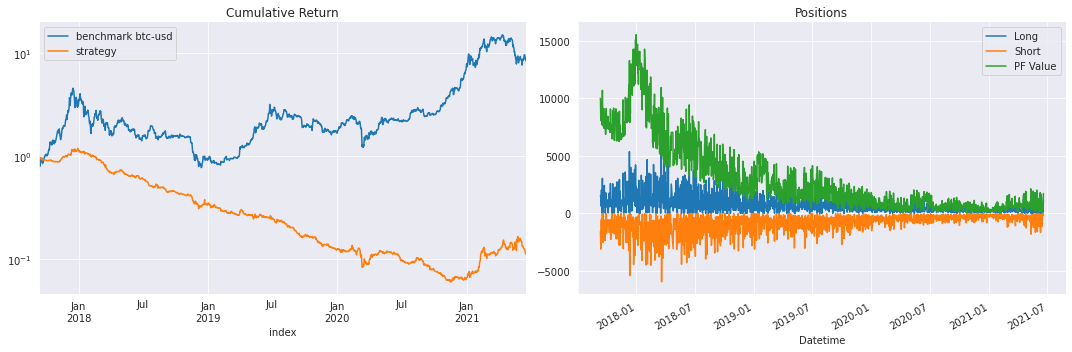

In [72]:
benchmark_btc2 = benchmark_btc['close'].pct_change().rename('btc/usd-benchmark')

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
log_axs=1
if log_axs:
    axes[0].set_yscale('log')
    benchmark_btc2.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
    returns.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label='strategy')
else:
    benchmark_btc2.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
    returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label='strategy')
axes[0].legend()

daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())
longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout()


In [73]:
# prepare pyfolio inputs
#pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
#returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')


## Run pyfolio analysis

In [74]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')


Start date,2017-09-10
End date,2021-06-19
Total months,65
,Backtest
Annual return,-32.798%
Cumulative returns,-88.639%
Annual volatility,37.073%
Sharpe ratio,-0.89
Calmar ratio,-0.35
Stability,0.90
Max drawdown,-94.937%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,94.94,2017-12-29,2020-11-19,NaT,NaN
1,12.96,2017-09-11,2017-11-07,2017-11-26,55
2,5.15,2017-12-21,2017-12-23,2017-12-29,7
3,4.80,2017-12-13,2017-12-19,2017-12-21,7
4,3.14,2017-11-26,2017-11-29,2017-12-01,5


Stress Events,mean,min,max
New Normal,-0.13%,-15.19%,26.05%


Top 10 long positions of all time,max
sid,
chz-usd,112.62%
vet-usd,79.01%
dgb-usd,74.32%
btc-usd,42.77%
eth-usd,42.52%
ltc-usd,41.95%
btt-usd,41.65%
miota-usd,41.49%
bnt-usd,41.06%


Top 10 short positions of all time,max
sid,
vet-usd,-227.35%
algo-usd,-89.91%
btt-usd,-89.80%
bat-usd,-88.99%
eos-usd,-88.07%
bsv-usd,-87.52%
ftt-usd,-87.43%
etc-usd,-87.22%
eth-usd,-86.49%


Top 10 positions of all time,max
sid,
vet-usd,227.35%
chz-usd,112.62%
algo-usd,89.91%
btt-usd,89.80%
bat-usd,88.99%
eos-usd,88.07%
bsv-usd,87.52%
ftt-usd,87.43%
etc-usd,87.22%


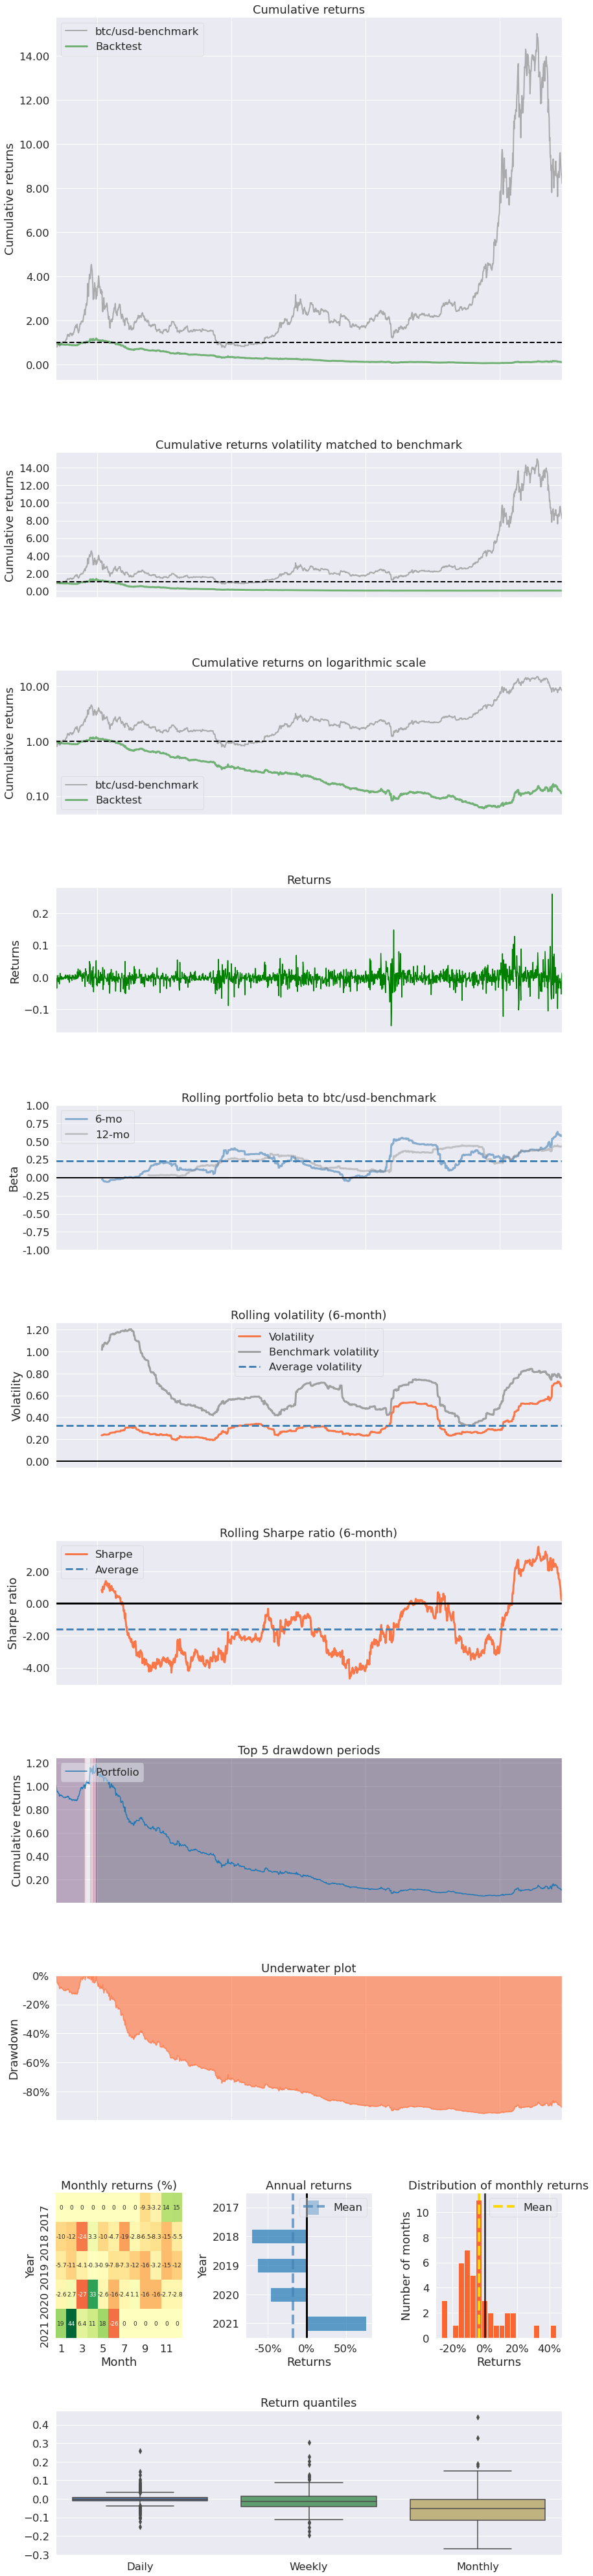

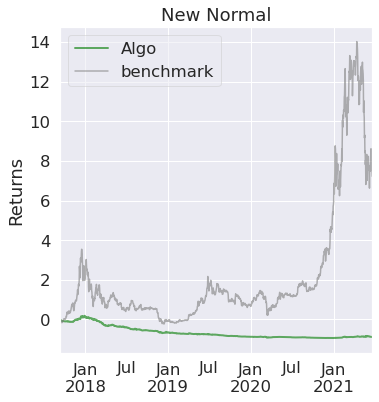

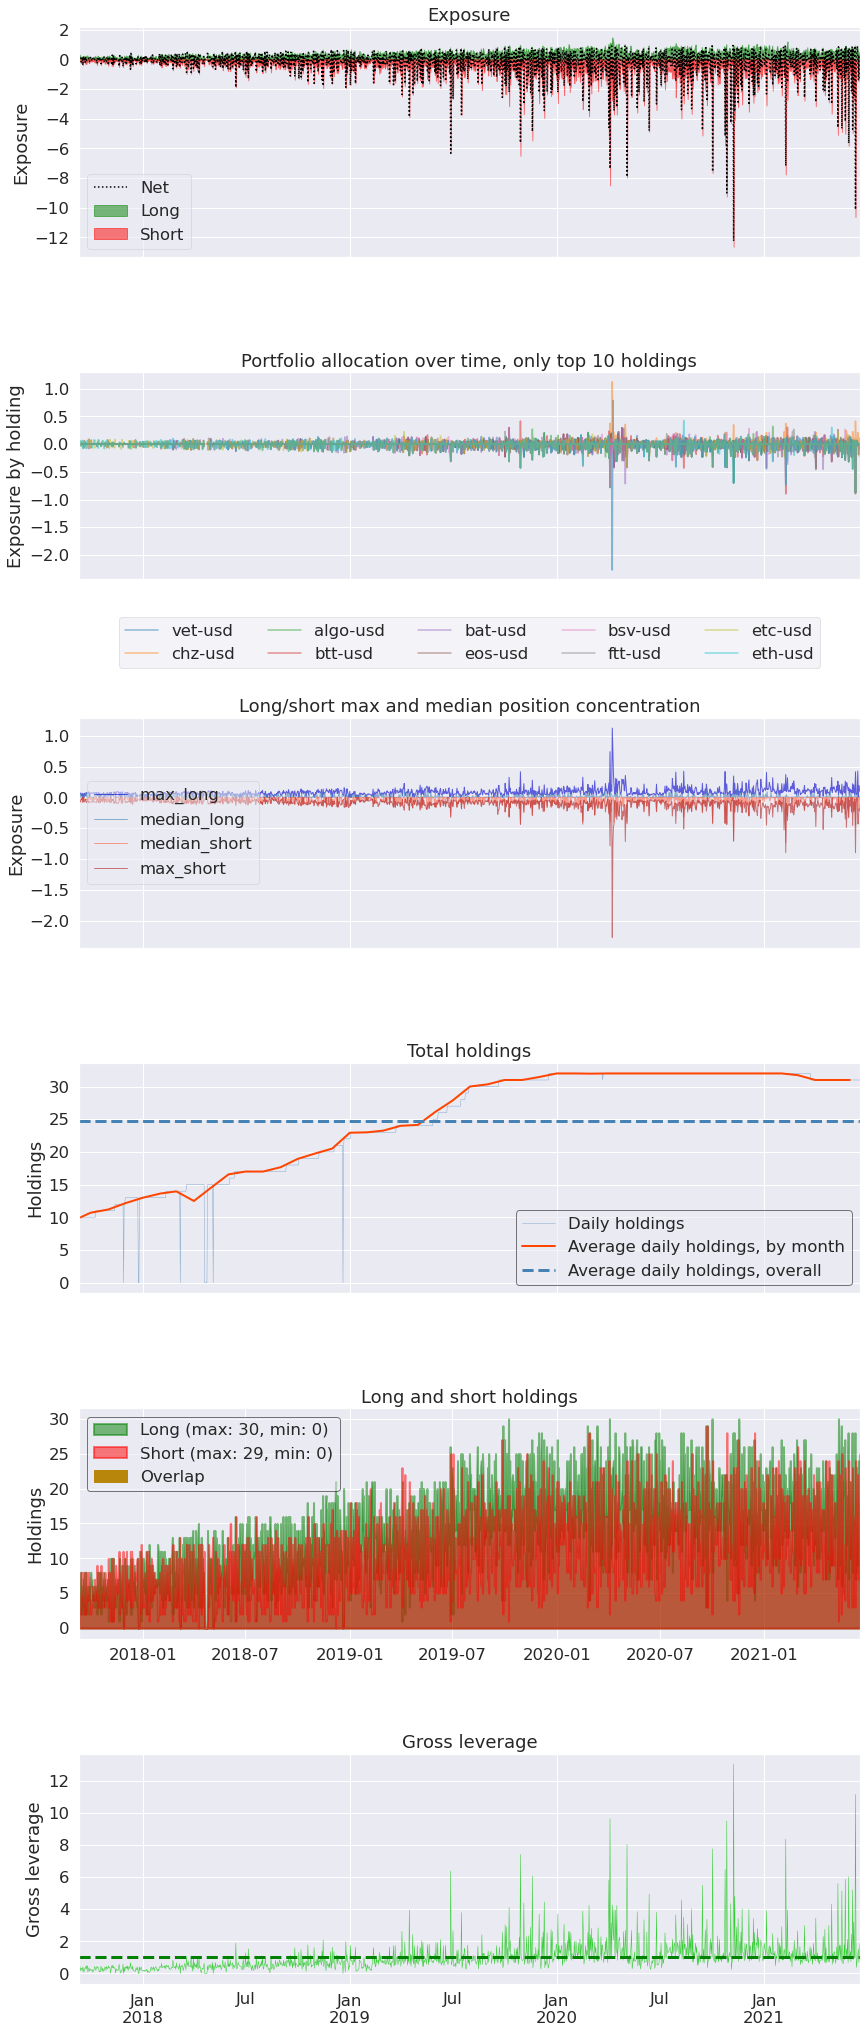

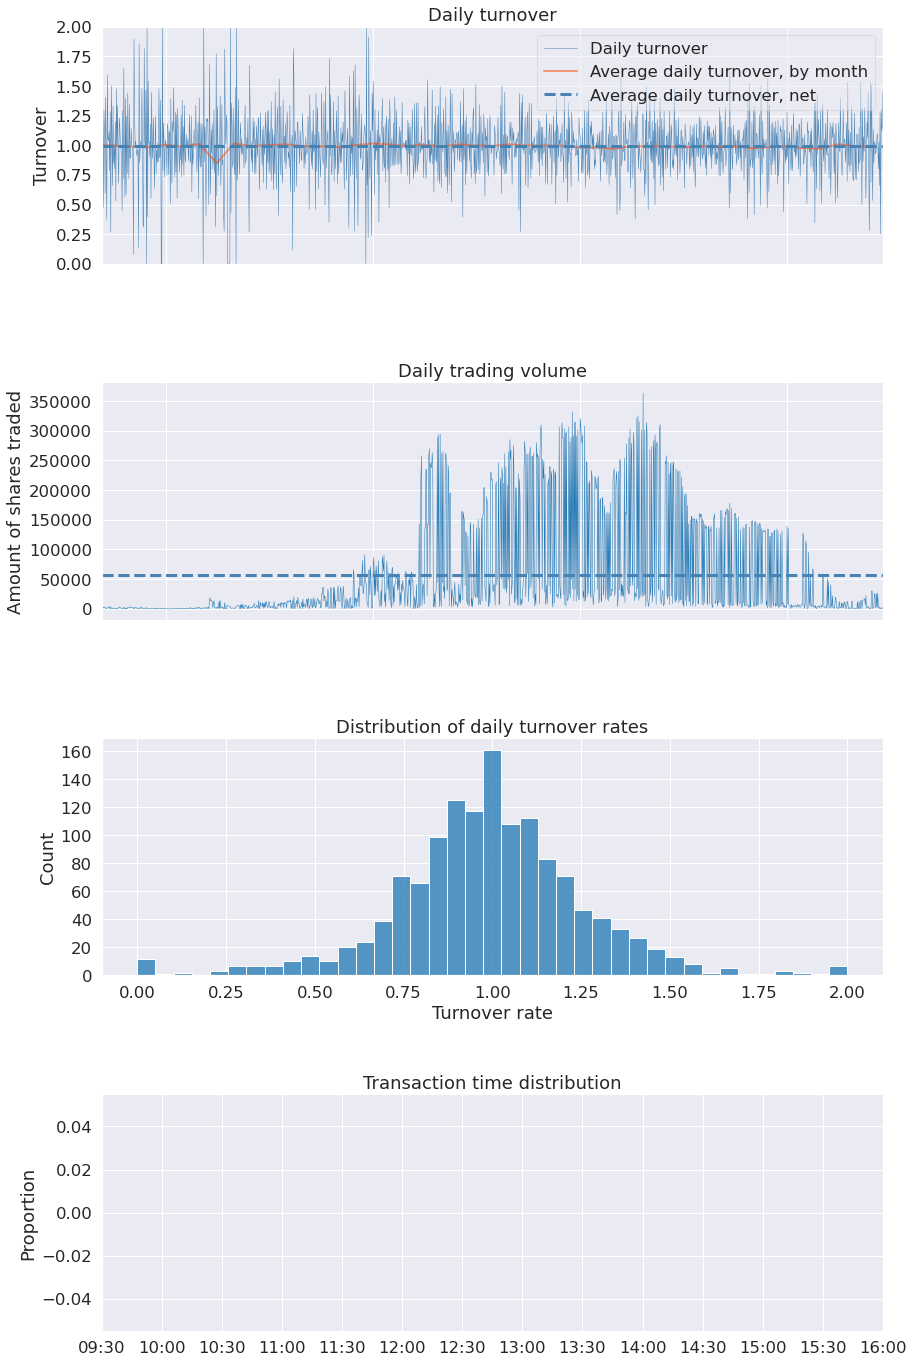

In [75]:
pyfolio = pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_btc2)


